In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())


True


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import shutil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms, datasets
from torchvision.utils import make_grid

from models import ConvVAE
from train import train_model, vae_loss_function

In [4]:
TBOARD_LOGS = os.path.join(os.getcwd(), "tboard_logs")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)

In [5]:
if not os.path.exists("imgs"):
    os.makedirs("imgs")
if not os.path.exists("imgs/ConvVAE"):
    os.makedirs("imgs/ConvVAE")

### a) AFHQ (Animal Faces-HQ) dataset

In [6]:
IMG_SIZE = 64

# Downloading and Loading Dataset
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),  # Downsaple to 64x64
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='./data/train', transform=transform)
test_dataset = datasets.ImageFolder(root='./data/test', transform=transform)

In [7]:
# Fitting data loaders for iterating
B_SIZE = 256

train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset, 
        batch_size=B_SIZE, 
        shuffle=True,
        num_workers=4
) 
test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset, 
        batch_size=B_SIZE,
        shuffle=False,
        num_workers=4
)

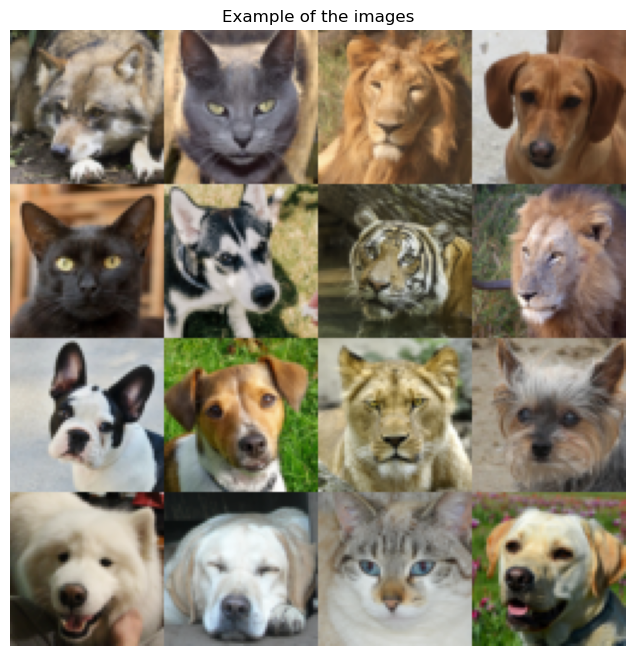

In [8]:
images, labels = next(iter(train_loader))

grid_img = make_grid(images[:16], nrow=4, padding=0, normalize=True)

np_img = grid_img.permute(1, 2, 0).numpy()

plt.figure(figsize=(8, 8))
plt.imshow(np_img)
plt.axis("off")
plt.title("Example of the images")
plt.show()

### b) Convolutional Variational Autoencoder (ConvVAE)

Defined in `models.py`

### c) Investigate the importance of the KL-divergence weight

In [9]:
EPOCHS = 10 # after 10 epochs there is no much improvement
LEARNING_RATE = 3e-3

In [ ]:
import time

kl_weights = [1e-3, 1e-2, 1e-1, 5e-1]
models = {}
training_stats = {}

start_time = time.time()

for weight in kl_weights:
    print(f"Training model with KL weight: {weight}")

    model = ConvVAE()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1)

    train_loss, val_loss, loss_iters, val_loss_recons, val_loss_kld = train_model(
            model=model, optimizer=optimizer, scheduler=scheduler, criterion=vae_loss_function,
            train_loader=train_loader, valid_loader=test_loader, num_epochs=EPOCHS,
            device=device, kl_weight=weight
        )
    
    models[weight] = model

end_time = time.time()
diff_min = (end_time - start_time) / 60 

print(f"Finished in {diff_min:.2f} minutes")

Training model with KL weight: 0.001
    Train loss: 0.05421
    Valid loss: 0.06042
       Valid loss recons: 0.06041
       Valid loss KL-D:   0.01021
    Train loss: 0.03969
    Valid loss: 0.04026
       Valid loss recons: 0.03416
       Valid loss KL-D:   6.09722
Saved state to checkpoints/16-43_30-05-2025/checkpoint_epoch_5.pth
    Train loss: 0.03689
    Valid loss: 0.03668
       Valid loss recons: 0.02999
       Valid loss KL-D:   6.69097
    Train loss: 0.03659
    Valid loss: 0.03625
       Valid loss recons: 0.02905
       Valid loss KL-D:   7.19443
    Train loss: 0.03643
    Valid loss: 0.03602
       Valid loss recons: 0.02841
       Valid loss KL-D:   7.60985
Saved state to checkpoints/16-43_30-05-2025/checkpoint_epoch_10.pth
    Train loss: 0.03632
    Valid loss: 0.03613
       Valid loss recons: 0.0288
       Valid loss KL-D:   7.33154
Training completed
Training model with KL weight: 0.01
    Train loss: 0.05794
    Valid loss: 0.05932
       Valid loss recons: 0.05

<b>Analysis:</b>

### d) Generate new images by sampling latent vectors, investigate latent space and visualize some interpolations.

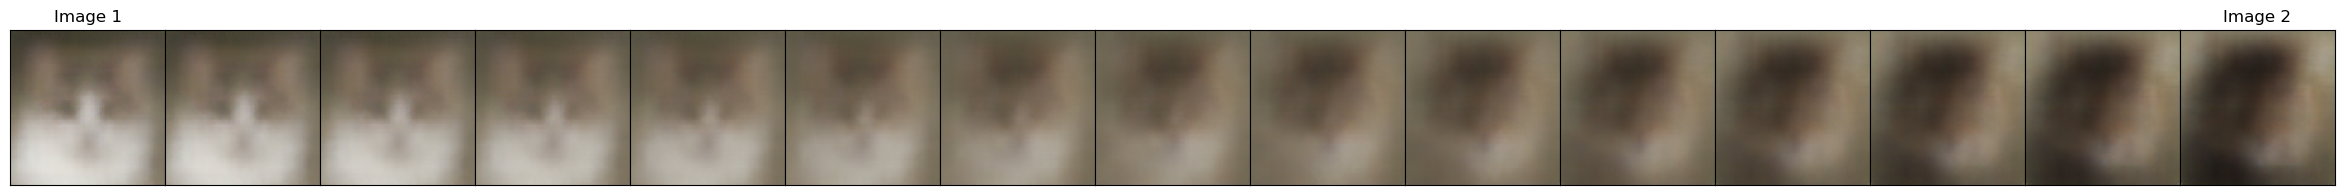

In [18]:
from utils.encode_samples import encode_samples
from utils.sample_interpolation import sample_interpolation
from utils.visualize_vector_samples import visualize_vector_samples

images, labels = next(iter(test_loader))
img1 = images[0]
img2 = images[1]

p1, p2 = encode_samples(models[kl_weights[0]], [img1, img2], device=device)
decoded_imgs = sample_interpolation(model=models[kl_weights[0]], p1=p1, p2=p2, device=device)
visualize_vector_samples(decoded_imgs)

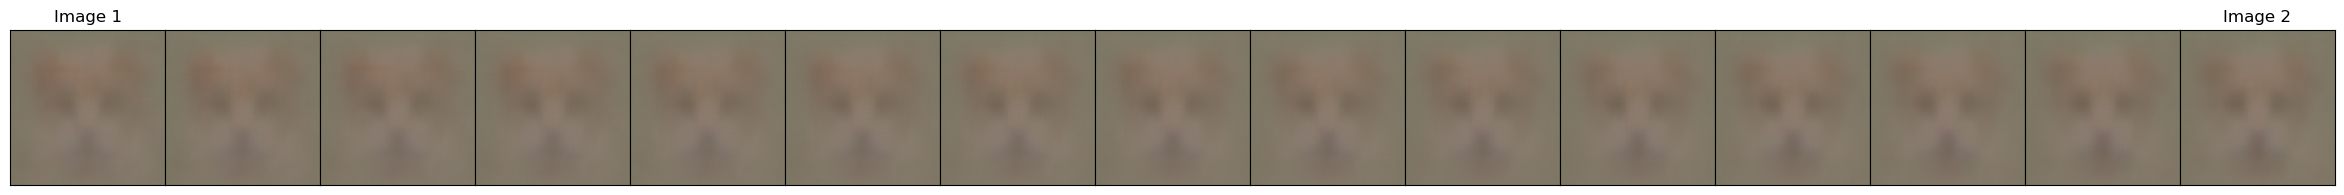

In [19]:
p1, p2 = encode_samples(models[kl_weights[-1]], [img1, img2], device=device)
decoded_imgs = sample_interpolation(model=models[kl_weights[-1]], p1=p1, p2=p2, device=device)
visualize_vector_samples(decoded_imgs)